## MSstatsTMT Analysis：Proteomics differential expression downstream analysis

#### The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsTMT](https://github.com/bigbio/proteomicstmt): TMT pipeline based on OpenMS and nextflow.

For the data with isobaric labeling, using the [MSstatsTMT](https://www.bioconductor.org/packages/release/bioc/html/MSstatsTMT.html) to perform the downstream data analysis. Major steps in the data processing are the following:

- Importing data from the pipeline. The major source of data are:
  - out.mzTab
  - metadata.sdrf.tsv or experimental_design.tsv 

### Convert out.mzTab to MSstatsTMT report from OpenMS

In [2]:
from pyteomics import mztab
import pandas as pd
import re
from sdrf_pipelines.openms.openms import OpenMS


def convert(mztab_file, out_msstats, exp_design=None, sdrf=None):
    print("Generating file ........")
    mz = mztab.MzTab(mztab_file)
    pep_table = mz.peptide_table
    meta_data = mz.metadata
    OutDataFrame = list()
    tech_map = dict()
    if sdrf:
        OpenMS.openms_convert(sdrf)
        exp_design = './experimental_design.tsv'

    with open(exp_design, 'r') as f:
        data = f.readlines()
        empty_row = data.index('\n')
        f_table = [i.replace('\n', '').split('\t') for i in data[1:empty_row]]
        f_table = pd.DataFrame(f_table)
        s_table = [i.replace('\n', '').split('\t') for i in data[data.index('\n') + 1:]][1:]
        s_header = data[data.index('\n') + 1].replace('\n', '').split('\t')
        s_DataFrame = pd.DataFrame(s_table, columns=s_header)

    for _, row in f_table.iterrows():
        mix = s_DataFrame[s_DataFrame['Sample'] == row[4]]['MSstats_Mixture'].values[0]
        if mix in tech_map:
            if row[2] not in tech_map[mix]:
                tech_map[mix].append(row[2])
        else:
            tech_map[mix] = [row[2]]

    for _, row in pep_table.iterrows():
        
        # remove the decoy
        if row['opt_global_cv_MS:1002217_decoy_peptide'] == 1 or 'DECOY' in row['accession']:
            continue
        spectra_ref = meta_data[row['spectra_ref'].split(':')[0] + '-location'].replace("file://", '')
        channels = f_table[f_table[2] == spectra_ref][3].tolist()  # assume order
        fraction = f_table[f_table[2] == spectra_ref][1].tolist()[0]
        run = row['spectra_ref'].split(':')[0]
        index = int(re.search(r'(\d+)', row['spectra_ref'].split(':')[0]).group(1))
        b = 1
        for channel in channels:
            sample = f_table[(f_table[2] == spectra_ref) & (f_table[3] == channel)][4].tolist()[0]
            position = s_DataFrame[s_DataFrame['Sample'] == sample]
            mixture = position['MSstats_Mixture'].values[0]
            TechRepMixture = str(mixture) + '_' + str(tech_map[mixture].index(spectra_ref) + 1)
            condition = position['MSstats_Condition'].values[0]
            BioReplicate = position['MSstats_BioReplicate'].values[0]
            intensity = row['peptide_abundance_study_variable[' + str(len(channels) * (index - 1) + b) + ']']
            b += 1
            OutDataFrame.append({'RetentionTime': row['retention_time'], 'ProteinName': row['accession'],
                                 'PeptideSequence': row['opt_global_cv_MS:1000889_peptidoform_sequence'],
                                 'Charge': row['charge'], 'Channel': channel, 'Condition': condition,
                                 'BioReplicate': BioReplicate, 'Run': run, 'Mixture': mixture,
                                 'TechRepMixture': TechRepMixture, 'Fraction': fraction,
                                 'Intensity': intensity, 'Reference': spectra_ref})

    d = pd.DataFrame(OutDataFrame, columns=['RetentionTime', 'ProteinName', 'PeptideSequence', 'Charge',
                                            'Channel', 'Condition', 'BioReplicate', 'Run', 'Mixture',
                                            'TechRepMixture', 'Fraction', 'Intensity', 'Reference'])
    
    d.to_csv(out_msstats, sep='\t', header=True, index=False)

if __name__ == '__main__':
    convert("../data/out.mzTab",
            '../data/out_msstats.csv',
            exp_design='../data/experimental_design.tsv'
            )

Generating file ........


In [3]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [4]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
data_folder = '../data/'
openms_output = '../data/out_msstats.csv'
setwd(data_folder)
raw.om <- read.csv(openms_output, header = TRUE, sep = '\t')
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)

INFO  [2021-07-28 19:02:54] ** Raw data from OpenMS imported successfully.
INFO  [2021-07-28 19:02:56] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-07-28 19:02:56] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-07-28 19:02:57] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-07-28 19:02:57] ** Shared peptides are removed.
INFO  [2021-07-28 19:02:57] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-07-28 19:03:30] ** PSMs have been aggregated to peptide ions.
INFO  [2021-07-28 19:03:31] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-07-28 19:03:31] ** Fractionation handled.
INFO  [2021-

### Protein summarization, normalization and visualization

INFO  [2021-07-28 19:18:52] ** MSstatsTMT - proteinSummarization function
INFO  [2021-07-28 19:18:52] Summarizing for Run : ms_run12 ( 1  of  12 )
  |======================================================================| 100%
INFO  [2021-07-28 19:19:06] Summarizing for Run : ms_run3 ( 2  of  12 )
  |======================================================================| 100%
INFO  [2021-07-28 19:19:23] Summarizing for Run : ms_run7 ( 3  of  12 )
  |======================================================================| 100%
INFO  [2021-07-28 19:19:37] Summarizing for Run : ms_run9 ( 4  of  12 )
  |======================================================================| 100%
INFO  [2021-07-28 19:19:53] Summarizing for Run : ms_run1 ( 5  of  12 )
  |======================================================================| 100%
INFO  [2021-07-28 19:20:09] Summarizing for Run : ms_run10 ( 6  of  12 )
  |======================================================================| 100%
INFO  [2021-

R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


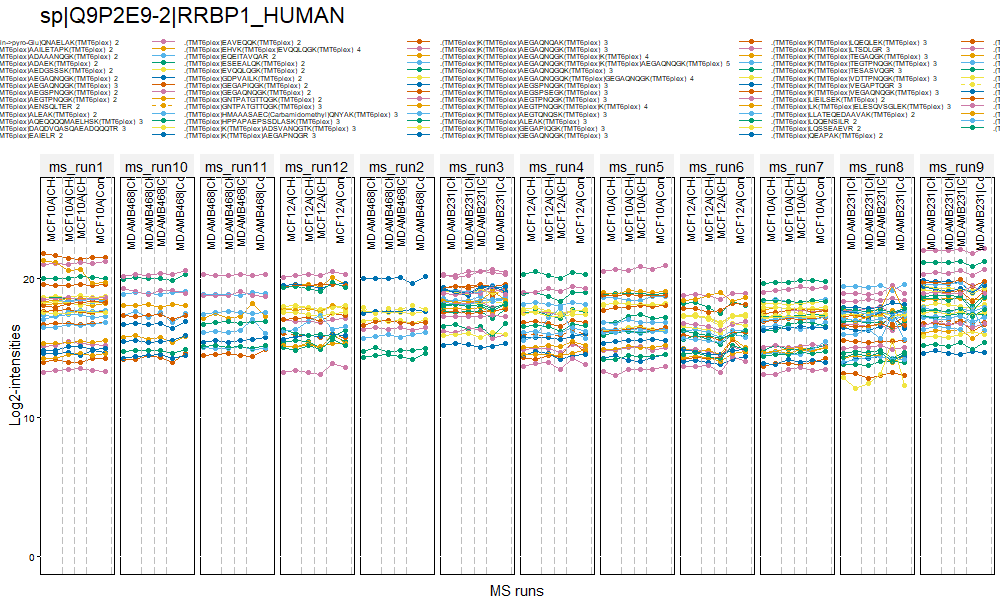

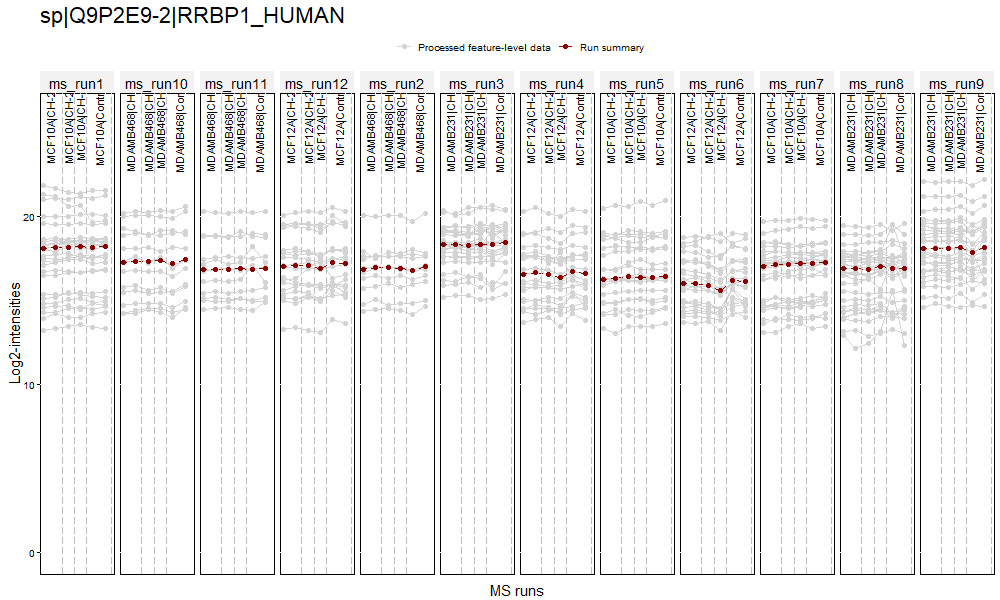

In [5]:
%%R -w 1000 -h 600

protein_expression = '../data/protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=TRUE,
                                      remove_norm_channel = TRUE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|Q9P2E9-2|RRBP1_HUMAN',
                     width = 21, # adjust the figure width 
                     height = 7,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



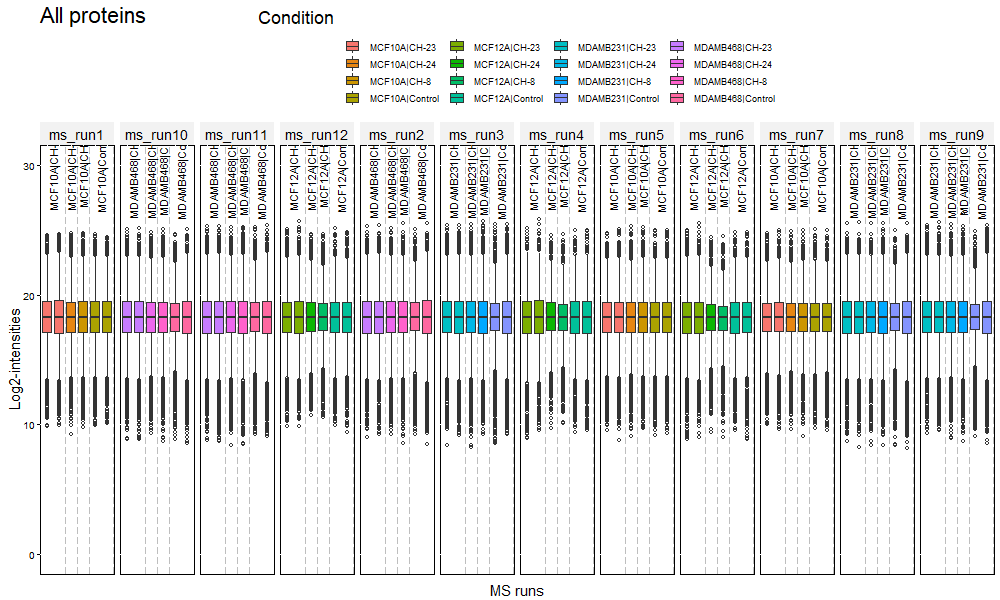

In [6]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 21, # adjust the figure width
                     height = 7,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [8]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

 [1] "MCF10A|CH-23"     "MCF10A|CH-24"     "MCF10A|CH-8"      "MCF10A|Control"  
 [5] "MCF12A|CH-23"     "MCF12A|CH-24"     "MCF12A|CH-8"      "MCF12A|Control"  
 [9] "MDAMB231|CH-23"   "MDAMB231|CH-24"   "MDAMB231|CH-8"    "MDAMB231|Control"
[13] "MDAMB468|CH-23"   "MDAMB468|CH-24"   "MDAMB468|CH-8"    "MDAMB468|Control"


In [16]:
%%R -w 1000 -h 600

MCF10A_Comp<-matrix(c(1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0, 0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0),nrow=3)
row.names(MCF10A_Comp)<-c("MCF10A|CH-23 vs MCF10A|Control", "MCF10A|CH-24 vs MCF10A|Control", "MCF10A|CH-8 vs MCF10A|Control")
colnames(MCF10A_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")


MCF10A.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MCF10A_Comp, moderated = TRUE)

INFO  [2021-07-28 19:42:58] Model fitting for 3344 proteins.
  |======================================================================| 100%
INFO  [2021-07-28 19:47:12] Testing for 3344 proteins:
  |======================================================================| 100%


In [17]:
%%R

head(MCF10A.pairwise$ComparisonResult)

                     Protein                          Label      log2FC
1: sp|A0A075B759|PAL4E_HUMAN MCF10A|CH-23 vs MCF10A|Control  0.05928981
2: sp|A0A075B759|PAL4E_HUMAN MCF10A|CH-24 vs MCF10A|Control  0.06183291
3: sp|A0A075B759|PAL4E_HUMAN  MCF10A|CH-8 vs MCF10A|Control  0.04426248
4: sp|A0A087X1C5|CP2D7_HUMAN MCF10A|CH-23 vs MCF10A|Control  0.18241147
5: sp|A0A087X1C5|CP2D7_HUMAN MCF10A|CH-24 vs MCF10A|Control -0.19794430
6: sp|A0A087X1C5|CP2D7_HUMAN  MCF10A|CH-8 vs MCF10A|Control  0.38116289
           SE        DF      pvalue adj.pvalue issue
1: 0.19228709 11.004260 0.763581948  0.9999359  <NA>
2: 1.09120328 11.506816 0.955784172  0.9840478  <NA>
3: 1.09120328 11.506816 0.968339567  0.9864152  <NA>
4: 0.06084981 41.004204 0.004604495  0.4335592  <NA>
5: 0.42282113  9.202019 0.650566912  0.8484296  <NA>
6: 0.42282113  9.202019 0.390319990  0.6762006  <NA>


#### Visualization MCF10A Cell line Condtion

In [18]:
%%R

MCF10A = MCF10A.pairwise$ComparisonResult
write.table(MCF10A,"MCF10A_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

                     Protein                           Label    log2FC  \
0  sp|A0A075B759|PAL4E_HUMAN  MCF10A|CH-23 vs MCF10A|Control  0.059290   
1  sp|A0A075B759|PAL4E_HUMAN  MCF10A|CH-24 vs MCF10A|Control  0.061833   
2  sp|A0A075B759|PAL4E_HUMAN   MCF10A|CH-8 vs MCF10A|Control  0.044262   
3  sp|A0A087X1C5|CP2D7_HUMAN  MCF10A|CH-23 vs MCF10A|Control  0.182411   
4  sp|A0A087X1C5|CP2D7_HUMAN  MCF10A|CH-24 vs MCF10A|Control -0.197944   

         SE         DF    pvalue  adj.pvalue issue  -Log10(p-value)    group  
0  0.192287  11.004260  0.763582    0.999936   NaN         0.117144  dimgrey  
1  1.091203  11.506816  0.955784    0.984048   NaN         0.019640  dimgrey  
2  1.091203  11.506816  0.968340    0.986415   NaN         0.013972  dimgrey  
3  0.060850  41.004204  0.004604    0.433559   NaN         2.336818    black  
4  0.422821   9.202019  0.650567    0.848430   NaN         0.186708  dimgrey  


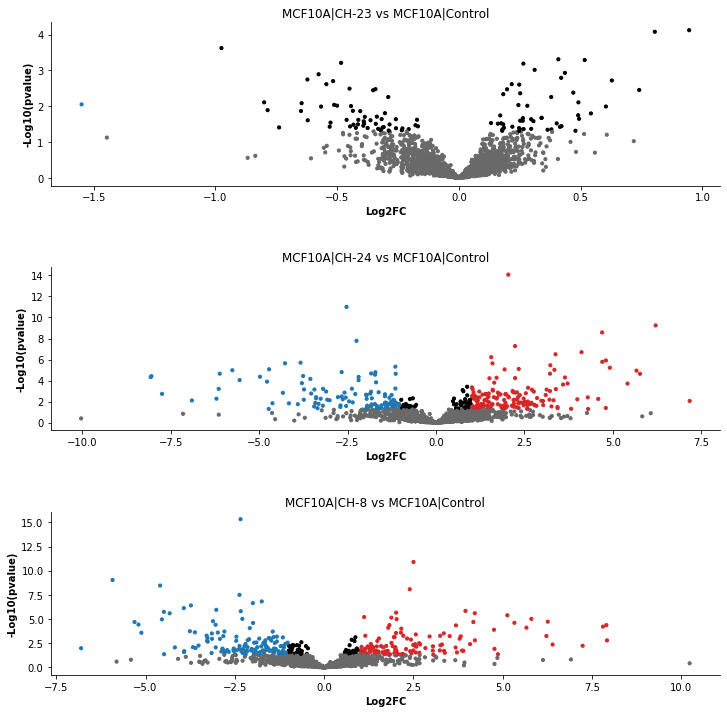

In [38]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt

result = pd.read_csv('../data/MCF10A_result.csv', sep=',')

result["-Log10(p-value)"] = -np.log10(result['pvalue'])
#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 1)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -1)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(12, 12))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(-2,10,3)) 
    ax.set_title(comp)
    i += 1

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### compare with article given 
#### The total protein given in the article and our difference protein intersection is 170. Because the article does not give the threshold of FC, the total difference protein of the article cannot be obtained . Among them, the top 10 difference protein intersection in the case of MCF10A CH-1 is 4

In [32]:
# map protein to gene name
import re
import urllib.parse
import urllib.request

def MapProtGeneName(prots):
    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(prots)
    params = {
    'from': 'ACC+ID',
    'to': 'GENENAME',
    'format': 'tab',
    'query':query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        data = response.decode('utf-8')
        return re.split('\t|\n', data)[3::2]

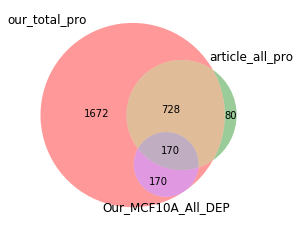

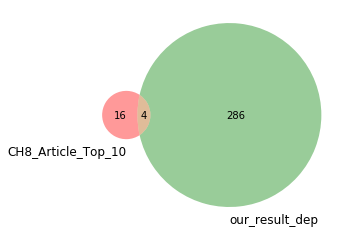

In [40]:
from matplotlib_venn import venn2, venn3
import pandas as pd
from matplotlib import pyplot as plt

# TOP ten protein per condition comparison
# 1. MCF10A  CH-23=CH-2  CH-8=CH-1  CH-24=CH-3
result = pd.read_csv('../data/MCF10A_result.csv', sep=',')

MCF10A_All = result['Protein'].tolist()

MCF10A_DEP = result[((result['log2FC'] > 0.606)&(result['pvalue'] < 0.05)) | ((result['log2FC'] < -0.606)&(result['pvalue'] < 0.05))]
CH8_all = MCF10A_DEP[MCF10A_DEP['Label'] == 'MCF10A|CH-8 vs MCF10A|Control']

# up proteins top 10
CH8_all.sort_values(["log2FC"],ascending=False).head(10)

# down protein top 10
CH8_all.sort_values(["log2FC"],ascending=False).tail(10)

# read data of the article
article_result = pd.read_excel("C:/Users/ChengXin/Desktop/PR/PXD009553/Perseus results.xlsx", header=0, sheet_name="MCF10A")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()
p1 = article_result['Gene names'].tolist()
article_top_10 = ['ME2', 'HIST3H2A', 'HMOX1', 'HSPA1B', 'HLA-C', 'HLA-A', 'ACBD3', 'HSPB1', 'B2M', 'P4HA1', 'HNRNPUL1', 'LUC7L3', 'S100A2',
                 'NUCKS1', 'PTMA', 'HMGN1', 'ETF1', 'BZW1', 'TXN2', 'EIF4B']

def preprocess(pro):
    return pro.split('|')[-1]
    
MCF10A_All = MapProtGeneName(list(map(preprocess, MCF10A_All))) 

our_result = MapProtGeneName(list(map(preprocess, CH8_all['Protein'].tolist())))
                             
MCF10A_All_DEP = MapProtGeneName(list(map(preprocess, MCF10A_DEP['Protein'].tolist())))

venn3(subsets=[set(MCF10A_All), set(p1), set(MCF10A_All_DEP)], set_labels=('our_total_pro','article_all_pro', 'Our_MCF10A_All_DEP'))
plt.show()

venn2(subsets=[set(article_top_10), set(our_result)], set_labels=('CH8_Article_Top_10', 'our_result_dep'))
plt.show()

#### the top 10 difference protein intersection in the case of MCF10A CH-2 is 0

['MGST3', 'PGRMC2', 'ALDH1A1', 'FTH1', 'PVR', 'YWHAE', 'ACTC1', 'H3-3A', 'H3-3B', 'SF3B3', 'HKDC1', 'HUWE1', 'SLC25A22', 'TANC2']


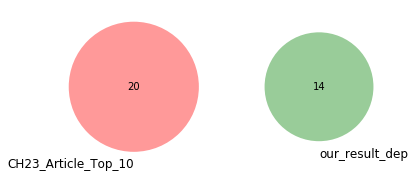

In [36]:
# MCF10A  CH-23=CH-2
CH23_all = MCF10A_DEP[MCF10A_DEP['Label'] == 'MCF10A|CH-23 vs MCF10A|Control']

# up proteins top 10
CH23_all.sort_values(["log2FC"],ascending=False).head(10)

# down protein top 10
CH23_all.sort_values(["log2FC"],ascending=False).tail(10)

# read data of the article
article_result = pd.read_excel("C:/Users/ChengXin/Desktop/PR/PXD009553/Perseus results.xlsx", header=0, sheet_name="MCF10A")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()
p1 = article_result['Gene names'].tolist()
article_top_10 = ['HSPA1B', 'HMOX1', 'SQSTM1', 'CRYAB', 'BAG3', 'HSPA6', 'P4HA1', 'HSPH1', 'HSP90AA1', 'HSPB1', 'GALNT2', 'INF2', 'DDX39A',
                 'PCNA', 'ACTB', 'EMG1', 'PSMD3', 'MT1E', 'EIF3D', 'DDX3X']

def preprocess(s):
    return s.split('|')[-1]

our_result = MapProtGeneName(list(map(preprocess, CH23_all['Protein'].tolist())))
print(our_result)

venn2(subsets=[set(article_top_10), set(our_result)], set_labels=('CH23_Article_Top_10', 'our_result_dep'))
plt.show()


#### the top 10 difference protein intersection in the case of MCF10A CH-2 is 2

['SMCHD1', 'AKR1B15', 'PSMD12', 'MPHOSPH10', 'EIF1AY', 'PSMA7', 'MGST3', 'HNRNPDL', 'LAMA5', 'ZNF185', 'OGT', 'BCAT2', 'HNRNPR', 'ANP32C', 'RGS10', 'ACTN4', 'RRP9', 'CALU', 'DHX16', 'TDRD6', 'MPDU1', 'PSIP1', 'NDUFS3', 'CBR3', 'ZMPSTE24', 'ATP5MG', 'MTA2', 'STK10', 'GFPT2', 'SUN1', 'GLS', 'AP2A2', 'LETM1', 'VAPB', 'CELF2', 'SMC2', 'POLR1A', 'HSPA4L', 'AP2A1', 'BAG2', 'AIFM1', 'SOD1', 'GOT2', 'PGK1', 'CST3', 'ALDOA', 'PRNP', 'SOD2', 'KRT6B', 'TUBB4A', 'RPLP1', 'SCG5', 'S100A6', 'ITGAV', 'LDHB', 'TUBB', 'PFN1', 'LAMB1', 'KRT19', 'RPSA', 'CLTB', 'HNRNPA1', 'SETSIP', 'U2AF1L5', 'PF4V1', 'HSPD1', 'LAMC1', 'UMPS', 'PYGB', 'MTHFD1', 'IGF2R', 'CKB', 'LAMP2', 'EEF2', 'LCP1', 'MYL6B', 'SNRPB', 'PVR', 'GSPT1', 'PGAM2', 'DSP', 'COX7C', 'STMN1', 'HSPA6', 'RPL35A', 'ARF4', 'VCL', 'RPL17', 'NDUFV2', 'CSRP1', 'GART', 'PAICS', 'UBA1', 'TCEA1', 'ITGA6', 'SFPQ', 'EIF4B', 'MCM3', 'PSMA3', 'MSN', 'NDUFS1', 'GRN', 'NOS3', 'ERP29', 'RPL12', 'PPP2R1A', 'NMT1', 'ALDH1B1', 'SDHA', 'SFN', 'PRDX2', 'RPL22', 'MYH9

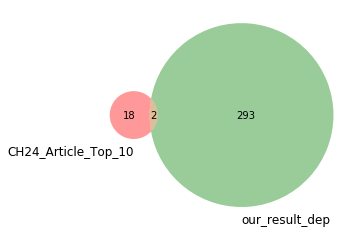

In [38]:
# MCF10A  CH-24=CH-3
CH24_all = MCF10A_DEP[MCF10A_DEP['Label'] == 'MCF10A|CH-24 vs MCF10A|Control']

# up proteins top 10
CH24_all.sort_values(["log2FC"],ascending=False).head(10)

# down protein top 10
CH24_all.sort_values(["log2FC"],ascending=False).tail(10)

# read data of the article
article_result = pd.read_excel("C:/Users/ChengXin/Desktop/PR/PXD009553/Perseus results.xlsx", header=0, sheet_name="MCF10A", )
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()
p1 = article_result['Gene names'].tolist()
article_top_10 = ['ME2', 'RPS27A', 'HSPA1B', 'HSPB1', 'HEATR1', 'CRYAB', 'HMOX1', 'SQSTM1', 'BAG3', 'HLA-A', 'HNRNPUL1', 'LUC7L3', 'PTMA',
                 'S100A2', 'HMGN1', 'EIF4B', 'OTUB1', 'NUCKS1', 'EIF4H', 'TNKS1BP1']

def preprocess(s):
    return s.split('|')[-1]

our_result = MapProtGeneName(list(map(preprocess, CH24_all['Protein'].tolist())))
print(our_result)

venn2(subsets=[set(article_top_10), set(our_result)], set_labels=('CH24_Article_Top_10', 'our_result_dep'))
plt.show()

###  Protein expression Heatmaps

#### report: From the expression heat map, in line with the results of the article, the expressions of non-cancer cell lines MCF10A and MCF12A are similar. Cancer cell lines MDA-MB-231 and MDA-MB-468 have similar expressions

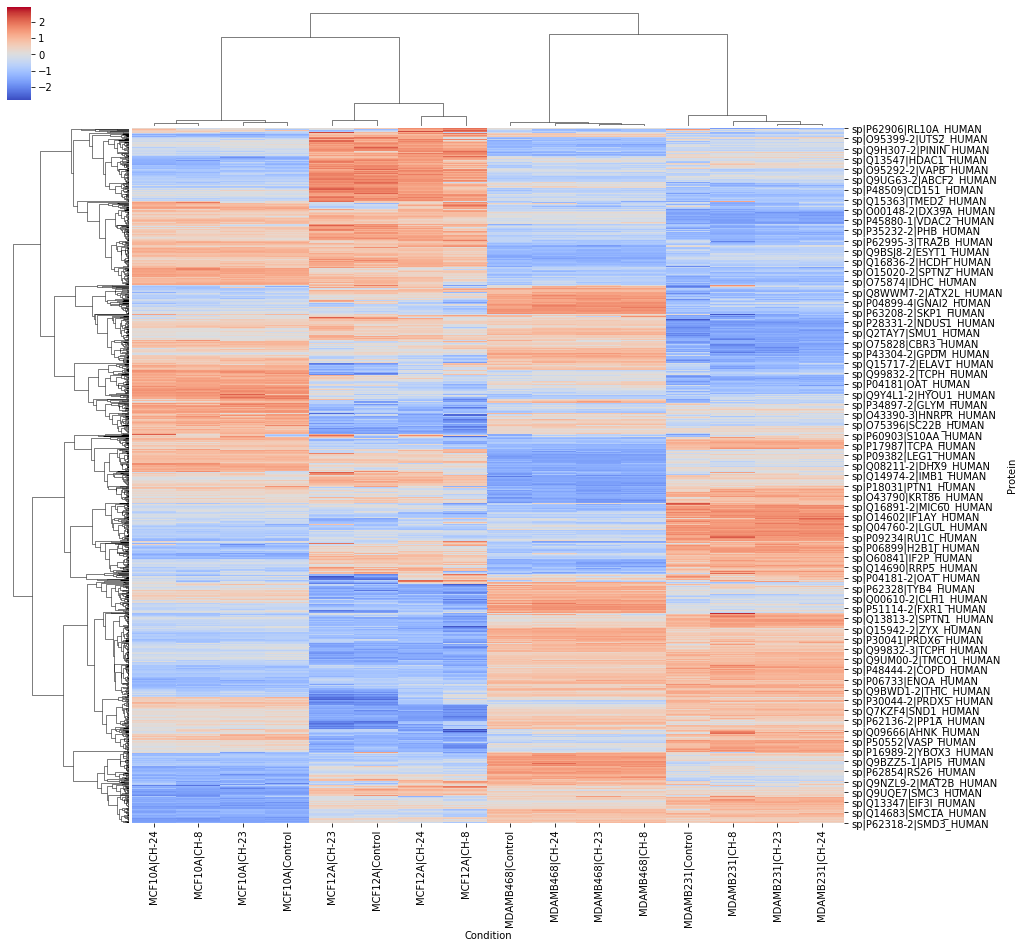

In [69]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
 
# Data set
url = '../data/protein_expression.csv'
df = pd.read_csv(url)

df2 = df.pivot_table(index='Protein', columns='Condition', values='Abundance',aggfunc=np.mean)
df2 = df2.dropna()

# plot
g = sns.clustermap(df2, method='average', metric='correlation', z_score=0, figsize=(15,15), xticklabels=True, cmap="coolwarm")
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels())#, fontsize = 5)

# tmp = g.ax_heatmap.get_xaxis()

threshold = 0.1
x_labels_ticks = g.ax_heatmap.get_xticklabels()

total_genes_above_threshold = 0
for i, xtickdata in enumerate(x_labels_ticks):
    protein = xtickdata._text
    if df2[protein].max() >= threshold:
        # print(df2[protein])
        # print("#########")
        total_genes_above_threshold = total_genes_above_threshold + 1
        # print(df2[protein].max())
    else:
        xtickdata._text = ''

#print("total_genes_above_threshold {}".format(total_genes_above_threshold))

# re set the tick labels with the modified list
g.ax_heatmap.set_xticklabels(x_labels_ticks)
plt.show()

### Visualization MDAMB231 Cell line Condtion

In [109]:
%%R -w 1000 -h 600

MDAMB231_Comp<-matrix(c(0,0,0,0,0,0,0,0,1,0,0,-1,0,0,0,0, 0,0,0,0,0,0,0,0,0,1,0,-1,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0),nrow=3)
row.names(MDAMB231_Comp)<-c("MDAMB231|CH-23 vs MDAMB231|Control", "MDAMB231|CH-24 vs MDAMB231|Control", "MDAMB231|CH-8 vs MDAMB231|Control")
colnames(MDAMB231_Comp) = c("MCF10A|CH-23","MCF10A|CH-24","MCF10A|CH-8","MCF10A|Control",
                        "MCF12A|CH-23","MCF12A|CH-24","MCF12A|CH-8","MCF12A|Control",
                        "MDAMB231|CH-23","MDAMB231|CH-24","MDAMB231|CH-8","MDAMB231|Control",
                        "MDAMB468|CH-23","MDAMB468|CH-24","MDAMB468|CH-8","MDAMB468|Control")
MDAMB231.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix =MDAMB231_Comp, moderated = TRUE)
write.table(MDAMB231.pairwise$ComparisonResult,"MDAMB231_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-07-29 13:49:00] Model fitting for 3344 proteins.
  |======================================================================| 100%
INFO  [2021-07-29 13:52:55] Testing for 3344 proteins:
  |======================================================================| 100%


                     Protein                               Label    log2FC  \
0  sp|A0A075B759|PAL4E_HUMAN  MDAMB231|CH-23 vs MDAMB231|Control  0.264597   
1  sp|A0A075B759|PAL4E_HUMAN  MDAMB231|CH-24 vs MDAMB231|Control -0.265187   
2  sp|A0A075B759|PAL4E_HUMAN   MDAMB231|CH-8 vs MDAMB231|Control -0.050172   
3  sp|A0A087X1C5|CP2D7_HUMAN  MDAMB231|CH-23 vs MDAMB231|Control -0.139217   
4  sp|A0A087X1C5|CP2D7_HUMAN  MDAMB231|CH-24 vs MDAMB231|Control  0.235374   

         SE         DF    pvalue  adj.pvalue issue  -Log10(p-value)    group  
0  1.096836  11.676829  0.813555    0.962699   NaN         0.089613  dimgrey  
1  1.091203  11.506816  0.812266    0.950677   NaN         0.090302  dimgrey  
2  0.192287  11.004260  0.798972    0.999431   NaN         0.097469  dimgrey  
3  0.600020   9.287614  0.821554    0.963326   NaN         0.085364  dimgrey  
4  0.598991   9.244755  0.703263    0.935541   NaN         0.152882  dimgrey  


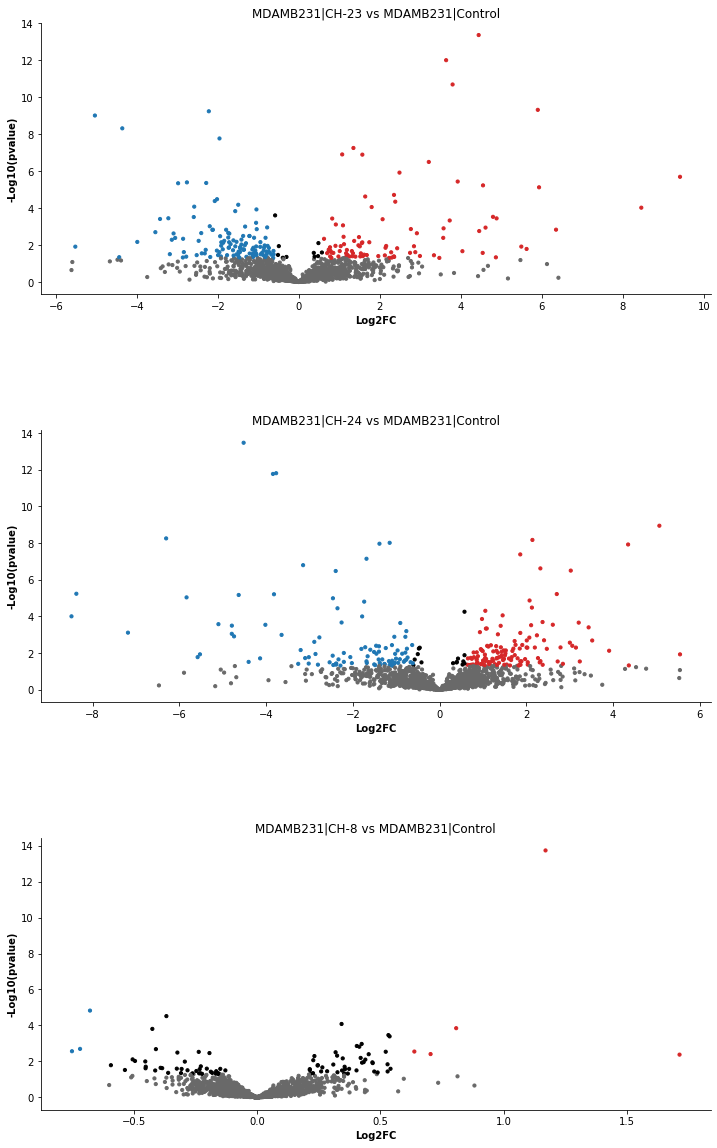

In [113]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt

result = pd.read_csv('../data/MDAMB231_result.csv', sep=',')

result["-Log10(p-value)"] = -np.log10(result['pvalue'])
#分组为up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > 0.606)&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < -0.606)&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=20
fig = plt.figure(figsize=(12, 20))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(310 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-0.606, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(0.606, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,4)) 
#     ax.set_yticks(range(-2,20,5)) 
    ax.set_title(comp)
    i += 1

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

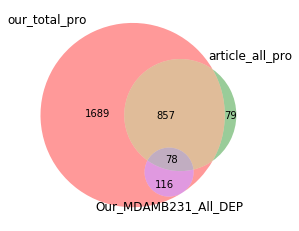

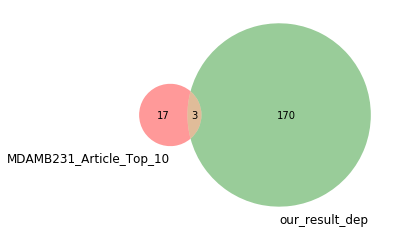

In [39]:
from matplotlib_venn import venn2, venn3

# TOP ten protein per condition comparison
# 1. MCF10A  CH-23=CH-2  CH-8=CH-1  CH-24=CH-3
result = pd.read_csv('../data/MDAMB231_result.csv', sep=',')

MDAMB231_All = result['Protein'].tolist()

MDAMB231_DEP = result[((result['log2FC'] > 1)&(result['pvalue'] < 0.05)) | ((result['log2FC'] < -1)&(result['pvalue'] < 0.05))]
CH23_all = MDAMB231_DEP[MDAMB231_DEP['Label'] == 'MDAMB231|CH-23 vs MDAMB231|Control']

# up proteins top 10
CH23_all.sort_values(["log2FC"],ascending=False).head(10)

# down protein top 10
CH23_all.sort_values(["log2FC"],ascending=False).tail(10)

# read data of the article
article_result = pd.read_excel("C:/Users/ChengXin/Desktop/PR/PXD009553/Perseus results.xlsx", header=0, sheet_name="MDA-MB-231")
# p1 = article_result[(article_result["Log2(CH-1/Control)"] > 0.606) | (article_result["Log2(CH-1/Control)"] < -0.606)]['Gene names'].tolist()
p1 = article_result['Gene names'].tolist()
article_top_10 = ['PITRM1', 'S100A6', 'SUPT16H', 'HSPA1B', 'CACYBP', 'HSPA6', 'PKD1', 'S100A2', 'RPS27A', 'BASP1', 'DNM1L', 'CCDC124', 'EFTUD2',
                 'NHP2L1', 'MYBBP1A', 'SPATS2L', 'HNRNPU', 'SNRNP200', 'SEC23A', 'CAMK2D']

def preprocess(s):
    return s.split('|')[-1]

MDAMB231_All = MapProtGeneName(list(map(preprocess,MDAMB231_All)))

our_result = MapProtGeneName(list(map(preprocess, CH23_all['Protein'].tolist())))
MDAMB231_All_DEP = MapProtGeneName(list(map(preprocess, MDAMB231_DEP['Protein'].tolist())))

venn3(subsets=[set(MDAMB231_All), set(p1), set(MDAMB231_All_DEP)], set_labels=('our_total_pro','article_all_pro', 'Our_MDAMB231_All_DEP'))
plt.show()

venn2(subsets=[set(article_top_10), set(our_result)], set_labels=('MDAMB231_Article_Top_10', 'our_result_dep'))
plt.show()